## Modules à importer

In [2]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [3]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)

z_max['SNF'] = [10, 10]
z_max['HST'] = [10, 10]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[1:]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][1])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][1])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_zcuts['SNF'],
                             x1_zcuts['SDSS'])),
             x1_zcuts['PS1'])),
         x1_zcuts['SNLS'])),
     x1_zcuts['HST']))
                                                     
datax_err_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_err_zcuts['SNF'],
                             x1_err_zcuts['SDSS'])),
             x1_err_zcuts['PS1'])),
         x1_err_zcuts['SNLS'])),
     x1_err_zcuts['HST']))
                                                     
dataz_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((z_zcuts['SNF'],
                             z_zcuts['SDSS'])),
             z_zcuts['PS1'])),
         z_zcuts['SNLS'])),
     z_zcuts['HST']))

zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys[1:]:
    zinf_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
    z_zinfcuts[survey] = surv[survey].zCMB.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = surv[survey].x1.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = surv[survey].x1ERR.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = surv[survey].c.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = surv[survey].cERR.values[zinf_cuts[survey]]
    
zinf_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][0])
z_zinfcuts['SNF'] = surv['SNF']['host.zcmb'].values[zinf_cuts['SNF']]
x1_zinfcuts['SNF'] = surv['SNF']['salt2.X1'].values[zinf_cuts['SNF']]
x1_err_zinfcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zinf_cuts['SNF']]
c_zinfcuts['SNF'] = surv['SNF']['salt2.Color'].values[zinf_cuts['SNF']]
c_err_zinfcuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zinf_cuts['SNF']]

datax_cons_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_zinfcuts['SNF'],
                             x1_zinfcuts['SDSS'])),
             x1_zinfcuts['PS1'])),
         x1_zinfcuts['SNLS'])),
     x1_zinfcuts['HST']))
                                                     
datax_err_cons_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_err_zinfcuts['SNF'],
                             x1_err_zinfcuts['SDSS'])),
             x1_err_zinfcuts['PS1'])),
         x1_err_zinfcuts['SNLS'])),
     x1_err_zinfcuts['HST']))
                                                     
dataz_cons_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((z_zinfcuts['SNF'],
                             z_zinfcuts['SDSS'])),
             z_zinfcuts['PS1'])),
         z_zinfcuts['SNLS'])),
     z_zinfcuts['HST']))

### Nb de données

In [4]:
s = 0
print('Conservative data:')
for survey in surveys:
    s += len(z_zinfcuts[survey])
    print(survey + ' =', len(z_zinfcuts[survey]))

print('Sum = ', s)

s = 0
print('Non-conservative data:')
for survey in surveys:
    s += len(z_zcuts[survey])
    print(survey + ' =', len(z_zcuts[survey]))

print('Sum = ', s)

Conservative data:
SNF = 141
SDSS = 82
PS1 = 122
SNLS = 78
HST = 26
Sum =  449
Non-conservative data:
SNF = 141
SDSS = 167
PS1 = 160
SNLS = 102
HST = 26
Sum =  596


## Utilisation de la classe _stretchevol_ pour le fit double total

In [5]:
reload(stretchevol)

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2S.GUESSVAL[3] = -1

evol3G2M2S.minimize()

evol3G2M2S_cons = stretchevol.Evol3G2M2S()
evol3G2M2S_cons.set_data(dataz_cons_all, datax_cons_all, datax_err_cons_all)

evol3G2M2S_cons.GUESSVAL[3] = -1

evol3G2M2S_cons.minimize()

#evol3G2M2S.plotter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

## Défnition _age-law_

In [8]:
def delta(z):
    return stretchevol.MockEvol().delta(z)

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] + (1-delta(z))*(res_SNF['a']*res_SNF['mu_1'] + 
                                                 (1-res_SNF['a'])*res_SNF['mu_2']))
    #return delta(z)*0.3869 + (1-delta(z))*(0.4772*0.3869 + (1-0.4772)*-1.5210)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.param['a']*evol3G2M2S.param['mu_1']
              + (1 - evol3G2M2S.param['a'])*evol3G2M2S.param['mu_2']))

def age_law_all_cons(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S_cons.param['mu_1']
      + (1-delta(z))*(evol3G2M2S_cons.param['a']*evol3G2M2S_cons.param['mu_1']
              + (1 - evol3G2M2S_cons.param['a'])*evol3G2M2S_cons.param['mu_2']))

def age_law_gen(z, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return (delta(z)*param_hesse[1]
      + (1-delta(z))*(param_hesse[0]*param_hesse[1]
              + (1 - param_hesse[0])*param_hesse[2]))

## Définition de _cov_ pour sélection aléatoire des paramètres

In [9]:
cov = im.Minuit.matrix(evol3G2M2S.m_tot)
mean = [evol3G2M2S.m_tot.values[i] for i in range(5)]
param_hesse_mat = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=500)

cov_cons = im.Minuit.matrix(evol3G2M2S_cons.m_tot)
mean_cons = [evol3G2M2S_cons.m_tot.values[i] for i in range(5)]
param_hesse_mat_cons = scipy.stats.multivariate_normal.rvs(mean=mean_cons, cov=cov_cons, size=500)

### Only take _a_, _µ1_ and _µ2_

In [10]:
param_hesse_cut = param_hesse_mat[:,[0,1,3]]

param_hesse_cut_cons = param_hesse_mat_cons[:,[0,1,3]]

### List of all the models

In [11]:
zlin = np.linspace(0, 2.65, 1000)
models_hesse = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut]
models_hesse = np.asarray(models_hesse)

models_hesse_cons = [[age_law_gen(zi, param_hesse_cons) for zi in zlin] for param_hesse_cons in param_hesse_cut_cons]
models_hesse_cons = np.asarray(models_hesse_cons)

### Take _std_

In [12]:
models_std = np.std(models_hesse, axis=0)

models_std_cons = np.std(models_hesse_cons, axis=0)

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [13]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

_, bins = np.histogram(dataz_all, histedges_equalN(dataz_all, 6))
_, bins_cons = np.histogram(dataz_all, histedges_equalN(dataz_cons_all, 6))

In [17]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')
display(cons)

Checkbox(value=False, description='Conservative')

## Utilisation de la classe _stretchevol_ pour le fit double

In [22]:
reload(stretchevol)

evolSNF = stretchevol.Evol3G2M2SSNF()
evolSNF.set_lssfr(d_snf['salt2.X1'], d_snf['salt2.X1.err'],
                  d_snf['lssfr'], d_snf['lssfr.err_down'], d_snf['lssfr.err_up'],
                  d_snf['p(prompt)'])

evolSNF.minimize()

#fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/BiGaussian.pdf', bbox_inches='tight')

## Définition de _cov_ pour sélection aléatoire des paramètres

In [25]:
cov_snf = im.Minuit.matrix(evolSNF.m_tot)
mean_snf = [evolSNF.m_tot.values[i] for i in range(5)]
param_hesse_mat_snf = scipy.stats.multivariate_normal.rvs(mean=mean_snf, cov=cov_snf, size=500)

### Only take _a_, _µ1_ and _µ2_

In [26]:
param_hesse_cut_snf = param_hesse_mat_snf[:,[0,1,3]]

### List of all the models

In [27]:
zlin = np.linspace(0, 2.65, 1000)
models_hesse_snf = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut_snf]
models_hesse_snf = np.asarray(models_hesse_snf)

### Take _std_

In [28]:
models_std_snf = np.std(models_hesse_snf, axis=0)

### Tracé des points

In [54]:
bins_used

array([0.02079894, 0.06228038, 0.11632667, 0.16595   , 0.2266    ,
       0.37073667, 2.26      ])

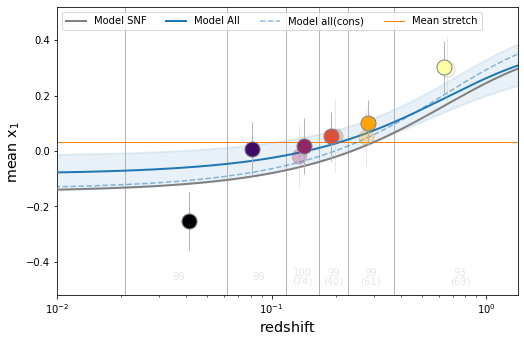

In [127]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
#ax2 = fig.add_axes([0.1, 1.05, 0.8, 0.8])

prop = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")

#ax.scatter(dataz_all, datax_all, color="0.7")

cmap = 'inferno'

if cons.value:
    bins_used = bins_cons
else:
    bins_used = bins

vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins_used)))
for i in range(len(bins)):
    ax.vline(bins_used[i], color="0.7", lw=1)

slices = []
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)

for i in range(6):
    slices.append(np.where((dataz_all > bins[i]) & (dataz_all <= bins_used[i+1])))
    x1_comp_mean[i] = np.mean(datax_all[slices[i]])
    x1_comp_std[i] = np.std(datax_all[slices[i]])
    z_comp_mean[i] = np.mean(dataz_all[slices[i]])
    z_comp_std[i] = np.std(dataz_all[slices[i]])
    
vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
               xerr = z_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               yerr = x1_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               color=vmap_s[i], **prop, zorder=10, lw=1)

#ax.plot(zz, np.mean(x1_z, axis=1),
#        color="0.5", lw=2, zorder=2, label="Age mock all")
#ax.plot(zz_all, np.mean(x1_z_all, axis=1), color="0.7", zorder=2, label="Age model all")

ax.plot(zlin, age_law_snf(zlin),
        color="0.5", lw=2, ls='-',
        label='Model SNF', zorder=6)

#ax.fill_between(zlin, age_law_snf(zlin) + models_std_snf,
#                age_law_snf(zlin) - models_std_snf,
#                color="C0", alpha=.1, lw=2)

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        label='Model All', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")


#ax.set_title('Model for non-conservative data')

###############################################################

#for i in range(len(bins_cons)):
#    ax.vline(bins_cons[i], color = vmap_v[i], alpha=.3)

slices_cons = []
x1_comp_mean_cons = np.zeros(6)
x1_comp_std_cons = np.zeros(6)
z_comp_mean_cons = np.zeros(6)
z_comp_std_cons = np.zeros(6)

bins_text = bins_used
bins_text[-1] = 1.4
shift_slices = [[0.007, 0],
                [0.008, 0],
                [0.016, 0.017],
                [0.015, 0.023],
                [0.029, 0.040],
                [0.180, 0.210]]

for i in range(6):
    slices_cons.append(np.where((dataz_cons_all > bins_used[i]) & (dataz_cons_all <= bins_used[i+1])))
    x1_comp_mean_cons[i] = np.mean(datax_cons_all[slices_cons[i]])
    x1_comp_std_cons[i] = np.std(datax_cons_all[slices_cons[i]])
    z_comp_mean_cons[i] = np.mean(dataz_cons_all[slices_cons[i]])
    z_comp_std_cons[i] = np.std(dataz_cons_all[slices_cons[i]])
    
    if len(dataz_all[slices[i]]) == len(dataz_cons_all[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(dataz_all[slices[i]])), alpha=.1)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(dataz_all[slices[i]])), alpha=.1)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(dataz_cons_all[slices_cons[i]])) + ')', alpha=.1)

for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
                xerr = z_comp_std_cons[i]/np.sqrt(len(dataz_cons_all[slices_cons[i]])),
                yerr = x1_comp_std_cons[i]/np.sqrt(len(dataz_cons_all[slices_cons[i]])),
                color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

#ax.plot(zz, np.mean(x1_z, axis=1),
#        color="0.5", lw=2, zorder=2, label="Age mock all")
#ax.plot(zz_all, np.mean(x1_z_all, axis=1), color="0.7", zorder=2, label="Age model all")

#ax2.plot(zlin, age_law_snf(zlin),
#         color="0.5", lw=2, ls='--',
#         label='Age model SNF')
#
ax.plot(zlin, age_law_all_cons(zlin),
        color="C0", lw=1.5, ls='--', alpha=.5,
        label='Model all(cons)', zorder=7)

ax.hline(np.mean(datax_all), color='C1', lw=1, ls='-', label='Mean stretch')

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

#
#ax.fill_between(zlin, age_law_all_cons(zlin) + models_std_cons,
#                age_law_all_cons(zlin) - models_std_cons,
#                color="C0", alpha=.1, lw=2, zorder=3)
#
#ax2.hline(np.mean(datax_cons_all), color='.5', lw=1, ls='--')
#
#ax2.tick_params(direction = 'in',
#                length = 5, width = 1,
#                labelsize = 12,
#                top = True, right = True)
#
##ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
#ax2.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")
#
#ax2.legend(ncol=1, loc='lower right')
#
##ax.set_ylim(-3, 3)
#ax2.set_ylim(-0.52, 0.52)
#ax2.set_xlim(0.01, 1.4)
#ax2.set_xscale('log')
#
#ax2.set_title('Model for conservative data')

ax.legend(ncol=4, loc='upper left')

fig=plt.gcf()
fig.savefig('../../../Images/stretchevol_all_vs_snf_maglim-cuts.pdf', bbox_inches='tight')

In [33]:
np.mean(datax_all)

-0.001531440657297817